<a href="https://colab.research.google.com/github/Kirilica98/omut/blob/main/OMUT_HW6_Zamogilnyi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import argparse
import os
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import GPT2TokenizerFast
import matplotlib.pyplot as plt

Класс 1-ой архитектуры со сверткой

In [4]:
class CausalConv1d(nn.Module):
    """
    Causal 1D convolution: pads input on the left so that output length equals input length.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.pad, dilation=dilation)

    def forward(self, x):
        # x: (batch, seq_len, channels)
        x = x.transpose(1, 2)  # (batch, channels, seq_len)
        y = self.conv(x)
        y = y[:, :, : x.size(2)]  # remove extra right padding
        return y.transpose(1, 2)

class ConvAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, conv_kernel=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.causal_conv = CausalConv1d(embed_dim, embed_dim, kernel_size=conv_kernel)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.to_logits = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, return_attn=False):
        seq_len = x.size(1)
        # Создаем маску с -inf вместо булевой
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(x.device)

        emb = self.embed(x)
        conv = self.causal_conv(emb)
        attn_out, attn_w = self.attn(
            query=conv,
            key=conv,
            value=conv,
            attn_mask=mask,  # Теперь маска с -inf
            need_weights=return_attn,
            average_attn_weights=False
        )
        logits = self.to_logits(attn_out)
        return (logits, attn_w) if return_attn else logits

Класс Att-Att модели

In [14]:
class AttentionAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.attn1 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.to_logits = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, return_attn=False):
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(x.device)

        emb = self.embed(x)
        out1, _ = self.attn1(emb, emb, emb, attn_mask=mask)
        out2, attn_w = self.attn2(out1, out1, out1,
                                 attn_mask=mask,
                                 need_weights=return_attn,
                                 average_attn_weights=False)
        logits = self.to_logits(out2)
        return (logits, attn_w) if return_attn else logits

In [7]:
def prepare_dataset(tokenizer, seq_len, dataset_name="wikitext", subset="wikitext-2-raw-v1"):
    ds = load_dataset(dataset_name, subset)

    # Токенизация текста
    def tokenize_fn(examples):
        return tokenizer(examples["text"], return_attention_mask=False)

    tokenized = ds.map(tokenize_fn, batched=True, remove_columns=["text"])

    # Группировка токенов в последовательности длиной seq_len
    def group_fn(examples):
        all_ids = sum(examples["input_ids"], [])
        total = len(all_ids)
        total = (total // seq_len) * seq_len
        chunks = [all_ids[i : i + seq_len] for i in range(0, total, seq_len)]
        return {"input_ids": chunks}

    grouped = tokenized.map(group_fn, batched=True)

    grouped.set_format(type="torch", columns=["input_ids"])

    return grouped["train"], grouped["validation"], grouped["test"]

In [8]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    correct = 0
    for batch in dataloader:
        x = batch["input_ids"].to(device)
        inputs = x[:, :-1]
        targets = x[:, 1:]
        optimizer.zero_grad()
        logits = model(inputs)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.reshape(-1)
        loss = F.cross_entropy(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * targets.size(0)
        total_tokens += targets.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == targets).sum().item()
    return total_loss / total_tokens, correct / total_tokens


def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch["input_ids"].to(device)
            inputs = x[:, :-1]
            targets = x[:, 1:]
            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.reshape(-1)
            loss = F.cross_entropy(logits, targets)
            total_loss += loss.item() * targets.size(0)
            total_tokens += targets.size(0)
            preds = logits.argmax(dim=-1)
            correct += (preds == targets).sum().item()
    return total_loss / total_tokens, correct / total_tokens

In [ ]:
args = {
'model': 'attn-attn',           # варианты: 'conv-attn', 'attn-attn'
'seq_len': 128,                 # длина входной последовательности
'batch_size': 32,               # размер батча
'epochs': 20,                    # число эпох
'lr': 1e-4,                     # learning rate
'embed_dim': 128,               # размер эмбеддингов
'num_heads': 4,                 # число голов внимания
'dataset': 'wikitext',          # название датасета HuggingFace
'subset': 'wikitext-2-raw-v1',  # сабсет датасета
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

train_ds, val_ds, _ = prepare_dataset(tokenizer, args['seq_len'] + 1,
                                      dataset_name=args['dataset'],
                                      subset=args['subset'])
train_loader = DataLoader(train_ds, batch_size=args['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=args['batch_size'])

vocab_size = tokenizer.vocab_size
if args['model'] == 'conv-attn':
    model = ConvAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
else:
    model = AttentionAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(1, args['epochs'] + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, \
          val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Plot training curves
epochs = range(1, args['epochs'] + 1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.png')

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_curve.png')

# Save model and convolutional weights for analysis
os.makedirs('checkpoints', exist_ok=True)
torch.save(model.state_dict(), f"checkpoints/{args['model']}_final.pt")

Epoch 1: train_loss=8.0014, train_acc=0.0455,           val_loss=7.5222, val_acc=0.0546
Epoch 2: train_loss=7.4013, train_acc=0.0656,           val_loss=7.2505, val_acc=0.1000
Epoch 3: train_loss=7.0863, train_acc=0.1116,           val_loss=7.0396, val_acc=0.1214
Epoch 4: train_loss=6.9029, train_acc=0.1218,           val_loss=6.9044, val_acc=0.1277
Epoch 5: train_loss=6.7901, train_acc=0.1260,           val_loss=6.8367, val_acc=0.1301
Epoch 6: train_loss=6.7188, train_acc=0.1290,           val_loss=6.7904, val_acc=0.1330
Epoch 7: train_loss=6.6588, train_acc=0.1315,           val_loss=6.7426, val_acc=0.1359
Epoch 8: train_loss=6.6010, train_acc=0.1342,           val_loss=6.6996, val_acc=0.1389
Epoch 9: train_loss=6.5455, train_acc=0.1365,           val_loss=6.6580, val_acc=0.1408
Epoch 10: train_loss=6.4951, train_acc=0.1387,           val_loss=6.6291, val_acc=0.1425
Epoch 11: train_loss=6.4487, train_acc=0.1405,           val_loss=6.5975, val_acc=0.1446
Epoch 12: train_loss=6.4061, t

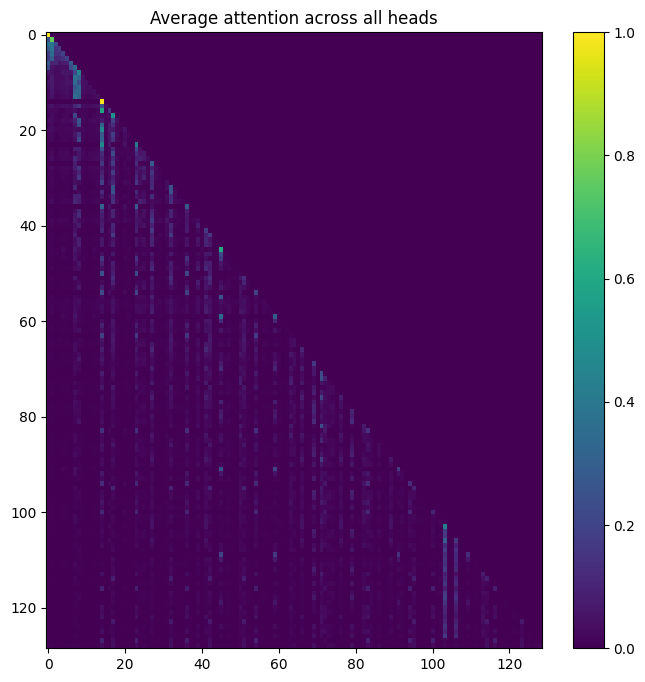

In [19]:
model.eval()
sample = next(iter(val_loader))["input_ids"][:1].to(device)
with torch.no_grad():
    # получение логитов и весов внимания
    logits, attn_w = model(sample, return_attn=True)
# attn_w: [batch=1, num_heads, seq_len, seq_len]
attn_map = attn_w.cpu().numpy()[0]  # shape: [num_heads, seq_len, seq_len]
num_heads = attn_map.shape[0]
# Сохраняем карту внимания для каждой головы
for h in range(num_heads):
    plt.figure(figsize=(5, 5))
    plt.imshow(attn_map[h], aspect='auto')
    plt.title(f'Attention map — head {h}')
    plt.colorbar()
    plt.savefig(f'attn_head_{h}.png')
    plt.close()
# Опционально: средняя карта по всем головам
mean_map = attn_map.mean(axis=0)
plt.figure(figsize=(8, 8))
plt.imshow(mean_map, aspect='auto')
plt.title('Average attention across all heads')
plt.colorbar()
plt.savefig('attn_mean.png')


Epoch 1: train_loss=7.8385, train_acc=0.0688,           val_loss=7.1665, val_acc=0.1199
Epoch 2: train_loss=6.9985, train_acc=0.1278,           val_loss=6.9531, val_acc=0.1401
Epoch 3: train_loss=6.8069, train_acc=0.1442,           val_loss=6.7914, val_acc=0.1570
Epoch 4: train_loss=6.6136, train_acc=0.1682,           val_loss=6.5625, val_acc=0.1962
Epoch 5: train_loss=6.0189, train_acc=0.2701,           val_loss=5.4404, val_acc=0.3753


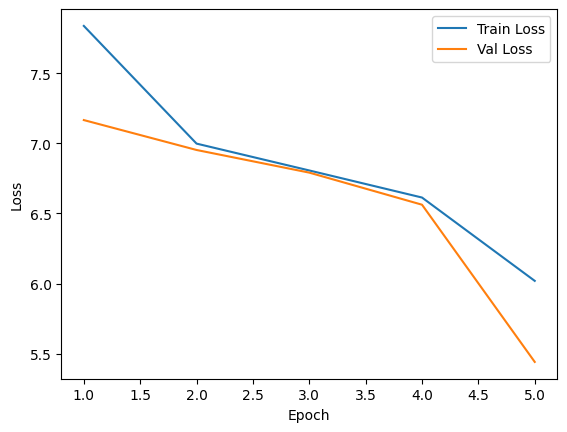

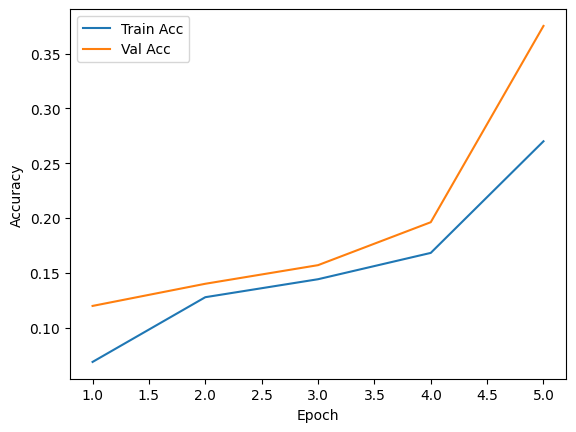

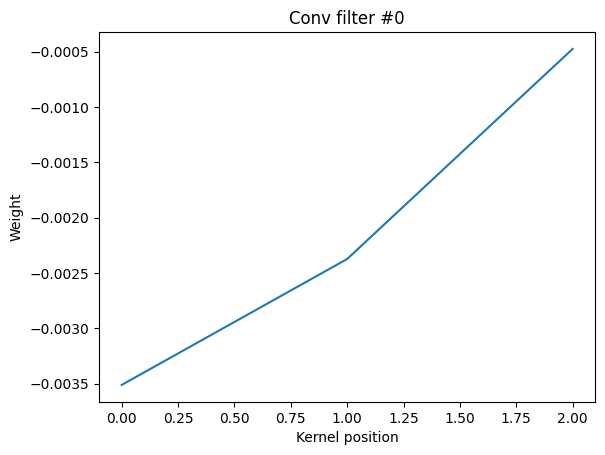

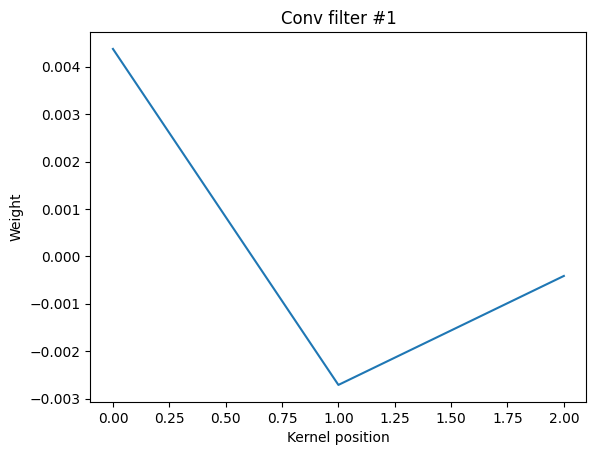

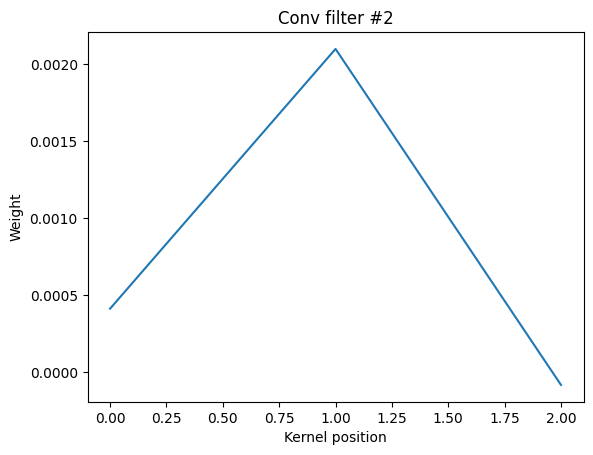

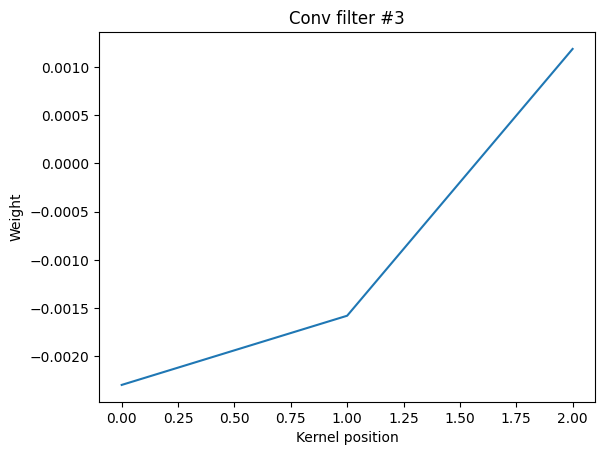

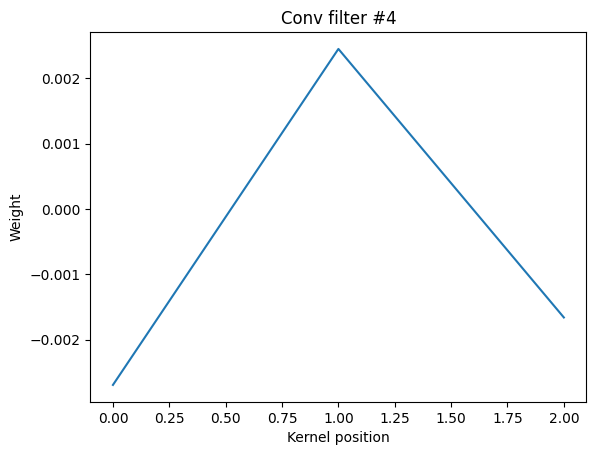

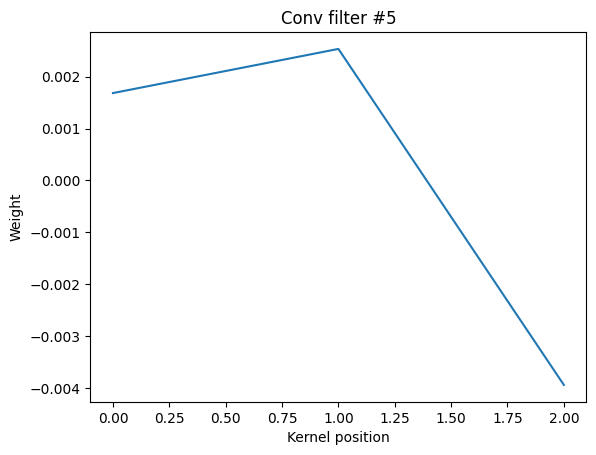

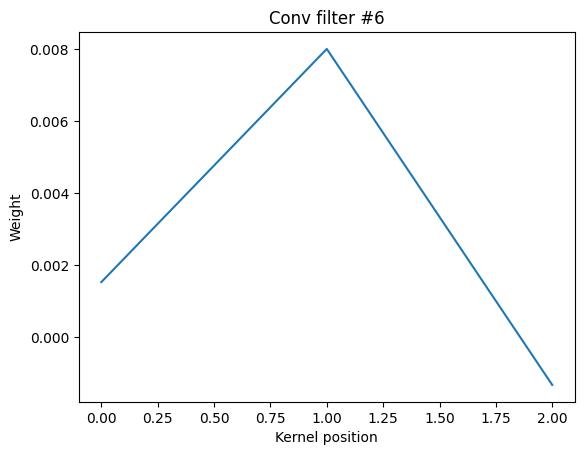

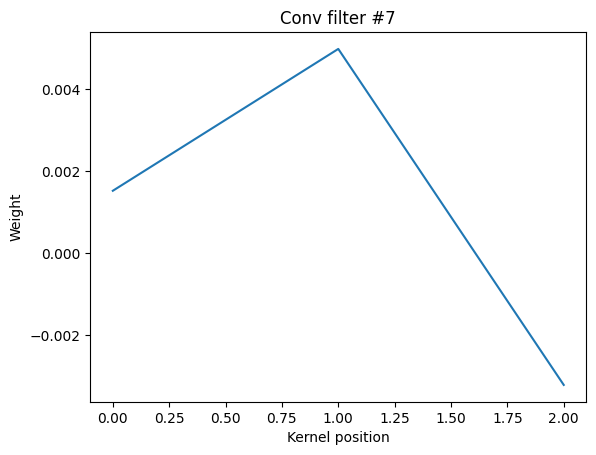

In [9]:
args = {
'model': 'conv-attn',           # варианты: 'conv-attn', 'attn-attn'
'seq_len': 128,                 # длина входной последовательности
'batch_size': 32,               # размер батча
'epochs': 5,                    # число эпох
'lr': 1e-4,                     # learning rate
'embed_dim': 128,               # размер эмбеддингов
'num_heads': 4,                 # число голов внимания
'dataset': 'wikitext',          # название датасета HuggingFace
'subset': 'wikitext-2-raw-v1',  # сабсет датасета
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

train_ds, val_ds, _ = prepare_dataset(tokenizer, args['seq_len'] + 1,
                                      dataset_name=args['dataset'],
                                      subset=args['subset'])
train_loader = DataLoader(train_ds, batch_size=args['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=args['batch_size'])

vocab_size = tokenizer.vocab_size
if args['model'] == 'conv-attn':
    model = ConvAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
else:
    model = AttentionAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(1, args['epochs'] + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, \
          val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Plot training curves
epochs = range(1, args['epochs'] + 1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.png')

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_curve.png')

# Save model and convolutional weights for analysis
os.makedirs('checkpoints', exist_ok=True)
torch.save(model.state_dict(), f"checkpoints/{args['model']}_final.pt")

if args['model'] == 'conv-attn':
    weights = model.causal_conv.conv.weight.data.cpu().numpy()  # [out_dim, in_dim, kernel]
    avg_filters = weights.mean(axis=1)  # усредняем по входным каналам -> [out_dim, kernel]
    num_plots = min(8, avg_filters.shape[0])
    for i in range(num_plots):
        plt.figure()
        plt.plot(avg_filters[i])
        plt.title(f'Conv filter #{i}')
        plt.xlabel('Kernel position'); plt.ylabel('Weight')
        plt.savefig(f'conv_filter_{i}.png')

# 2) Визуализация attention-карт


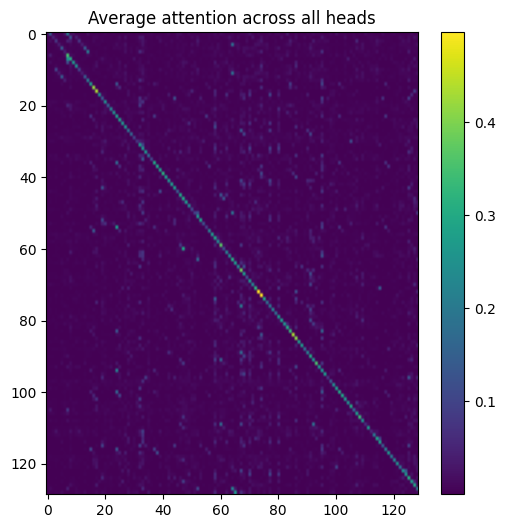

In [10]:
model.eval()
sample = next(iter(val_loader))["input_ids"][:1].to(device)
with torch.no_grad():
    # получение логитов и весов внимания
    logits, attn_w = model(sample, return_attn=True)
# attn_w: [batch=1, num_heads, seq_len, seq_len]
attn_map = attn_w.cpu().numpy()[0]  # shape: [num_heads, seq_len, seq_len]
num_heads = attn_map.shape[0]
# Сохраняем карту внимания для каждой головы
for h in range(num_heads):
    plt.figure(figsize=(5, 5))
    plt.imshow(attn_map[h], aspect='auto')
    plt.title(f'Attention map — head {h}')
    plt.colorbar()
    plt.savefig(f'attn_head_{h}.png')
    plt.close()
# Опционально: средняя карта по всем головам
mean_map = attn_map.mean(axis=0)
plt.figure(figsize=(6, 6))
plt.imshow(mean_map, aspect='auto')
plt.title('Average attention across all heads')
plt.colorbar()
plt.savefig('attn_mean.png')